<a href="https://colab.research.google.com/github/nitekar/Kamaro_IMLSummative/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name : Kamaro vulnerability classification
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import xgboost as xgb

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


# The Dataset
> ***Brief Description:***
State the Problem and A short Description of the data


###Problem: Fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities.

###Dataset contains some socio-economic and health factors that determine the overall development of the country.


In [ ]:
def load_kamaro_data(filepath):
    df = pd.read_csv("Country-data.csv")

    df['country'] = pd.qcut(df['child_mort'], q=3, labels=[0, 1, 2])

    # Drop unused
    features = df.drop(['child_mort', 'country'], axis=1)
    labels = df['country'].astype(int)

    return train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

X_train, X_test, y_train, y_test = load_kamaro_data("Country-data.csv")

# Optional scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (133, 8), Test set: (34, 8)


#SECTION 1: Model Architecture:



```
TODO: Insert an image with the Model architecture here.Replace the image Below
```
> <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*v1ohAG82xmU6WGsG2hoE8g.png" alt="?" style="width:25px"/>




#Task: Define a function that creates models without and With specified Optimization techniques


In [ ]:
#Logistic Regression
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

lr_model = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=5, scoring='f1_macro')
lr_model.fit(X_train_scaled, y_train)

lr_best = lr_model.best_estimator_
lr_pred = lr_best.predict(X_test_scaled)

print("Best Params:", lr_model.best_params_)
print("Accuracy:", accuracy_score(y_test, lr_pred))
print("F1 Score:", f1_score(y_test, lr_pred, average='macro'))


Best Params: {'C': 0.01, 'solver': 'lbfgs'}
Accuracy: 0.8235294117647058
F1 Score: 0.8184149184149184


In [ ]:
# Simple Neural Network
def build_simple_nn(input_dim, num_classes):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

simple_model = build_simple_nn(X_train_scaled.shape[1], 3)
simple_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

simple_preds = np.argmax(simple_model.predict(X_test_scaled), axis=1)
print("Simple NN Accuracy:", accuracy_score(y_test, simple_preds))



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Simple NN Accuracy: 0.8235294117647058


In [ ]:
def build_optimized_nn(input_dim, num_classes, optimizer='adam', lr=0.001, dropout=0.3, l2_reg=0.001):
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(l2_reg), input_shape=(input_dim,)),
        Dropout(dropout),
        Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(dropout),
        Dense(32, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dense(num_classes, activation='softmax')
    ])

    if optimizer == 'adam':
        opt = Adam(learning_rate=lr)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=lr)
    else:
        opt = SGD(learning_rate=lr)

    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
results = []
histories = []
predictions = []

configs = [
    {'optimizer': 'adam', 'lr': 0.001, 'dropout': 0.3, 'l2': 0.001, 'early_stop': False},
    {'optimizer': 'adam', 'lr': 0.01, 'dropout': 0.4, 'l2': 0.01, 'early_stop': True},
    {'optimizer': 'rmsprop', 'lr': 0.005, 'dropout': 0.5, 'l2': 0.005, 'early_stop': False},
    {'optimizer': 'sgd', 'lr': 0.01, 'dropout': 0.2, 'l2': 0.01, 'early_stop': True},
    {'optimizer': 'adam', 'lr': 0.1, 'dropout': 0.6, 'l2': 0.1, 'early_stop': False},
]

for i, cfg in enumerate(configs):
    print(f"\nTraining NN Instance {i+1}")
    model = build_optimized_nn(X_train_scaled.shape[1], 3,
                               optimizer=cfg['optimizer'],
                               lr=cfg['lr'],
                               dropout=cfg['dropout'],
                               l2_reg=cfg['l2'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)] if cfg['early_stop'] else []

    history = model.fit(X_train_scaled, y_train,
                        validation_split=0.2,
                        epochs=100, batch_size=32,
                        callbacks=callbacks, verbose=0)

    pred = np.argmax(model.predict(X_test_scaled), axis=1)

    results.append({
        'Instance': i + 1,
        'Optimizer': cfg['optimizer'],
        'Learning_Rate': cfg['lr'],
        'Dropout': cfg['dropout'],
        'L2_Regularization': cfg['l2'],
        'Early_Stopping': 'Yes' if cfg['early_stop'] else 'No',
        'Epochs': len(history.history['loss']),
        'Accuracy': accuracy_score(y_test, pred),
        'F1': f1_score(y_test, pred, average='macro'),
        'Precision': precision_score(y_test, pred, average='macro'),
        'Recall': recall_score(y_test, pred, average='macro')
    })

    predictions.append(pred)
    histories.append(history)



Training NN Instance 1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Training NN Instance 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

Training NN Instance 3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

Training NN Instance 4
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

Training NN Instance 5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


# Task: Print out the Final Model Accuracy and plot the Loss curve

In [ ]:
results_df = pd.DataFrame(results)
print("Optimized Neural Network Results:")
print(results_df.round(4))


Optimized Neural Network Results:
   Instance Optimizer  Learning_Rate  Dropout  L2_Regularization  \
0         1      adam          0.001      0.3              0.001   
1         2      adam          0.010      0.4              0.010   
2         3   rmsprop          0.005      0.5              0.005   
3         4       sgd          0.010      0.2              0.010   
4         5      adam          0.100      0.6              0.100   

  Early_Stopping  Epochs  Accuracy      F1  Precision  Recall  
0             No     100    0.7647  0.7594     0.7608  0.7601  
1            Yes      28    0.8235  0.8165     0.8191  0.8207  
2             No     100    0.8824  0.8835     0.8881  0.8813  
3            Yes     100    0.8235  0.8184     0.8242  0.8207  
4             No     100    0.3529  0.1739     0.1176  0.3333  


In [ ]:
xgb_params = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(xgb.XGBClassifier(objective='multi:softmax', num_class=3),
                        xgb_params, cv=3, scoring='f1_macro', verbose=0)

xgb_grid.fit(X_train_scaled, y_train)
xgb_model = xgb_grid.best_estimator_

xgb_preds = xgb_model.predict(X_test_scaled)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))


XGBoost Accuracy: 0.7647058823529411


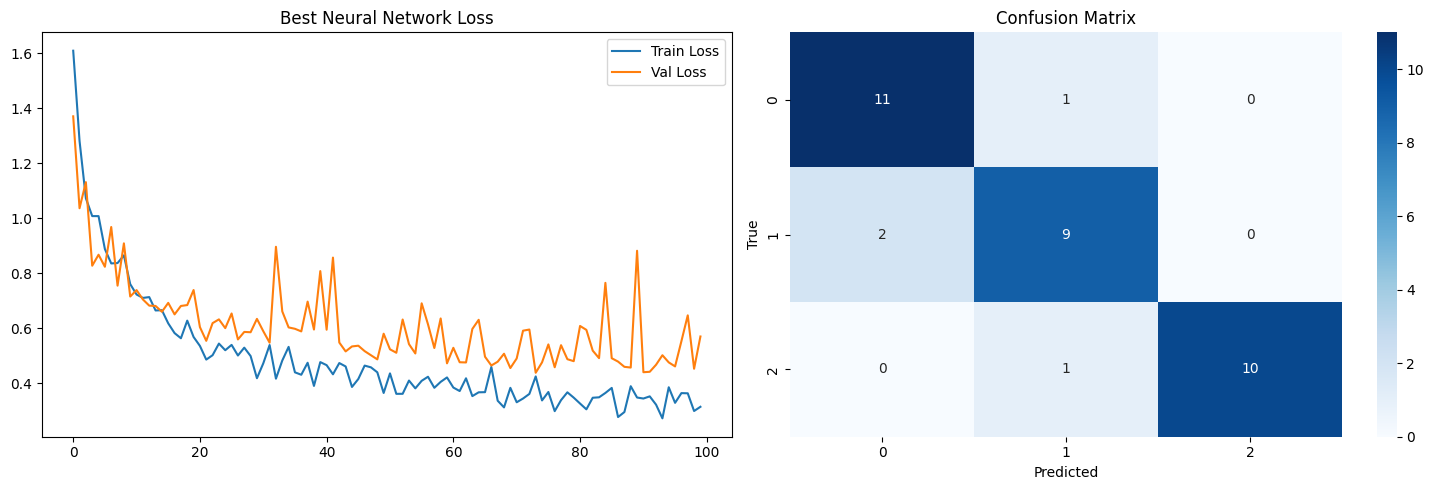

In [ ]:
best_idx = results_df['F1'].idxmax()
best_history = histories[best_idx]
best_pred = predictions[best_idx]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Val Loss')
plt.title('Best Neural Network Loss')
plt.legend()

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [ ]:
import os
best_model = build_optimized_nn(X_train_scaled.shape[1], 3,
                                optimizer=configs[best_idx]['optimizer'],
                                lr=configs[best_idx]['lr'],
                                dropout=configs[best_idx]['dropout'],
                                l2_reg=configs[best_idx]['l2'])

save_dir = 'saved_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory: {save_dir}")

best_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)
best_model.save('saved_models/best_kamaro_model.keras')


In [ ]:
loaded_model = load_model('saved_models/best_kamaro_model.keras')
preds = loaded_model.predict(X_test_scaled[:10])
classes = np.argmax(preds, axis=1)
print(classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
[1 0 1 1 2 1 2 1 0 0]


Congratulations!!
